In [122]:
import numpy as np
import matplotlib.pyplot as plt; plt.rc('font', size=12)
import pandas as pd
from collections import Counter
import seaborn as sns

In [123]:
taxa = ['B_cellulosilyticus_WH2', 
        'B_caccae', 
        'B_vulgatus', 
        'B_thetaiotaomicron', 
        'B_ovatus', 
        'R_obeum', 
        'B_uniformis', 
        'P_distasonis', 
        'C_scindens', 
        'C_aerofaciens', 
        'C_spiroforme', 
        # 'D_longicatena'
        ]

cols = ['#016bff',
        '#b91f1c',
        '#308937',
        '#ff8137',
        '#6f4fc7',
        '#d4b300',
        '#893a2b',
        '#ff6c79',
        '#16c4ff',
        '#766f41',
        '#00c800',
        '#af3261']

pretty_names_dir = {'B_caccae': '$B. caccae$',
                'B_cellulosilyticus_WH2': '$B. cellulosilyticus$',
                'B_ovatus': '$B. ovatus$',
                'B_thetaiotaomicron': '$B. thetaiotaomicron$',
                'B_uniformis': '$B. uniformis$',
                'B_vulgatus': '$B. vulgatus$',
                'C_aerofaciens': '$C. aerofaciens$',
                'C_scindens': '$C. scindens$',
                'C_spiroforme': '$C. spiroforme$',
                # 'D_longicatena': '$D. longicatena$',
                'P_distasonis': '$P. distasonis$',
                'R_obeum': '$R. obeum$'}

cols_species_map = dict(zip(taxa, cols))

In [124]:
def presence_absence(x):
    if pd.isna(x):
        return 0
    else:
        return 1
    
def drop_nan(x):
    if pd.isna(x):
        return False
    else:
        return True
    
def calculate_metabolic_distance(table):
    J = np.zeros([len(table.columns), len(table.columns)])
    for i in range(len(table.columns)):
        for j in range(len(table.columns)):
            if i == j:
                J[i,j] = 0
            else:
                set_rep = Counter(table.iloc[:,[i,j]].sum(axis=1))
                J[i,j] = 1 - (set_rep[2]/(set_rep[1]+set_rep[2]))
    return pd.DataFrame(J, index=table.columns, columns=table.columns)

def get_added_information(table):
    J = np.zeros([len(table.columns), len(table.columns)])
    probs = table.apply(sum, axis=1) / len(table.columns)
    for i in range(len(table.columns)):
        for j in range(len(table.columns)):
            if i == j:
                J[i,j] = 0
            else:
                K = table[(table.iloc[:,i] == 0) & (table.iloc[:,j] == 1)].copy().index
                J[i,j] = - np.sum(probs[K]*np.log(probs[K]))
    return pd.DataFrame(J, index=table.columns, columns=table.columns)

def get_aminoacid_metabolism(COG):
    return 'E' in COG

def get_carbohydrate_metabolism(COG):
    return 'G' in COG

# Carbohydrate metabolism

## Metabolic Distance and Metabolic Added Information

In [125]:
dbCAN_sub = []
for taxon in taxa:
    cazymes = pd.read_table(f'dbCAN3/{taxon}/overview.txt', sep='\t', index_col=1)
    cazymes['Species'] = taxon
    cazymes = cazymes[cazymes['#ofTools'] >= 2].loc[:, ['Species']].copy()
    cazymes.reset_index(inplace=True)
    cazymes.set_index('Species', inplace=True)
    cazymes = cazymes['EC#'].str.split('|', expand=True)
    cazymes.reset_index(inplace=True)
    cazymes = cazymes.melt(id_vars='Species', value_name='EC#')
    cazymes.drop(columns='variable', inplace=True)
    cazymes.dropna(inplace=True)
    cazymes = cazymes[cazymes['EC#'] != '-'].copy()
    cazymes['EC#'] = cazymes['EC#'].str.replace('-', '')
    cazymes.drop_duplicates(subset=['EC#'], inplace=True)
    cazymes.set_index('EC#', inplace=True)
    cazymes.columns = [cazymes['Species'][0]]
    dbCAN_sub.append(cazymes)
dbCAN_sub = pd.concat(dbCAN_sub, axis=1)
dbCAN_sub = dbCAN_sub.applymap(presence_absence)
dbCAN_sub

,B_cellulosilyticus_WH2,B_caccae,B_vulgatus,B_thetaiotaomicron,B_ovatus,R_obeum,B_uniformis,P_distasonis,C_scindens,C_aerofaciens,C_spiroforme
EC#,,,,,,,,,,,
3.2.1.55,1,1,1,1,1,1,1,1,0,0,0
3.2.1.37,1,1,1,1,1,1,1,1,0,1,1
3.2.1.,1,1,1,1,1,1,1,1,1,1,1
3.2.1.92,1,0,0,0,0,0,1,0,0,0,0
3.2.1.21,1,1,1,1,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
4.2.2.12,0,0,0,0,0,0,0,0,0,0,1
3.2.1.97,0,0,0,0,0,0,0,0,0,0,1
3.2.1.50,0,0,0,0,0,0,0,0,0,0,1


In [126]:
metdist_carbo = calculate_metabolic_distance(dbCAN_sub)
metdist_carbo = metdist_carbo.sort_index(axis=0).sort_index(axis=1)
metdist_carbo.to_csv('metabolic-metrics/metdist_carbo.tsv', sep='\t', index=True, header=True)
metdist_carbo_pretty = metdist_carbo.copy()
metdist_carbo_pretty.columns = metdist_carbo_pretty.columns.map(pretty_names_dir)
metdist_carbo_pretty.index = metdist_carbo_pretty.index.map(pretty_names_dir)
metdist_carbo_pretty

,$B. caccae$,$B. cellulosilyticus$,$B. ovatus$,$B. thetaiotaomicron$,$B. uniformis$,$B. vulgatus$,$C. aerofaciens$,$C. scindens$,$C. spiroforme$,$P. distasonis$,$R. obeum$
$B. caccae$,0.000000,0.532609,0.426829,0.457831,0.434211,0.438356,0.836364,0.833333,0.721311,0.424242,0.700000
$B. cellulosilyticus$,0.532609,0.000000,0.200000,0.250000,0.272727,0.348315,0.885057,0.892473,0.831579,0.526882,0.806452
$B. ovatus$,0.426829,0.200000,0.000000,0.176471,0.321839,0.237500,0.876543,0.872093,0.820225,0.440476,0.793103
$B. thetaiotaomicron$,0.457831,0.250000,0.176471,0.000000,0.370787,0.271605,0.875000,0.870588,0.790698,0.470588,0.790698
$B. uniformis$,0.434211,0.272727,0.321839,0.370787,0.000000,0.421687,0.859155,0.870130,0.797468,0.428571,0.750000
$B. vulgatus$,0.438356,0.348315,0.237500,0.271605,0.421687,0.000000,0.848485,0.861111,0.815789,0.432432,0.750000
$C. aerofaciens$,0.836364,0.885057,0.876543,0.875000,0.859155,0.848485,0.000000,0.814815,0.823529,0.842105,0.709677
$C. scindens$,0.833333,0.892473,0.872093,0.870588,0.870130,0.861111,0.814815,0.000000,0.820513,0.838710,0.685714
$C. spiroforme$,0.721311,0.831579,0.820225,0.790698,0.797468,0.815789,0.823529,0.820513,0.000000,0.750000,0.772727
$P. distasonis$,0.424242,0.526882,0.440476,0.470588,0.428571,0.432432,0.842105,0.838710,0.750000,0.000000,0.666667


/home/acs98/anaconda3/envs/py-workspace/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


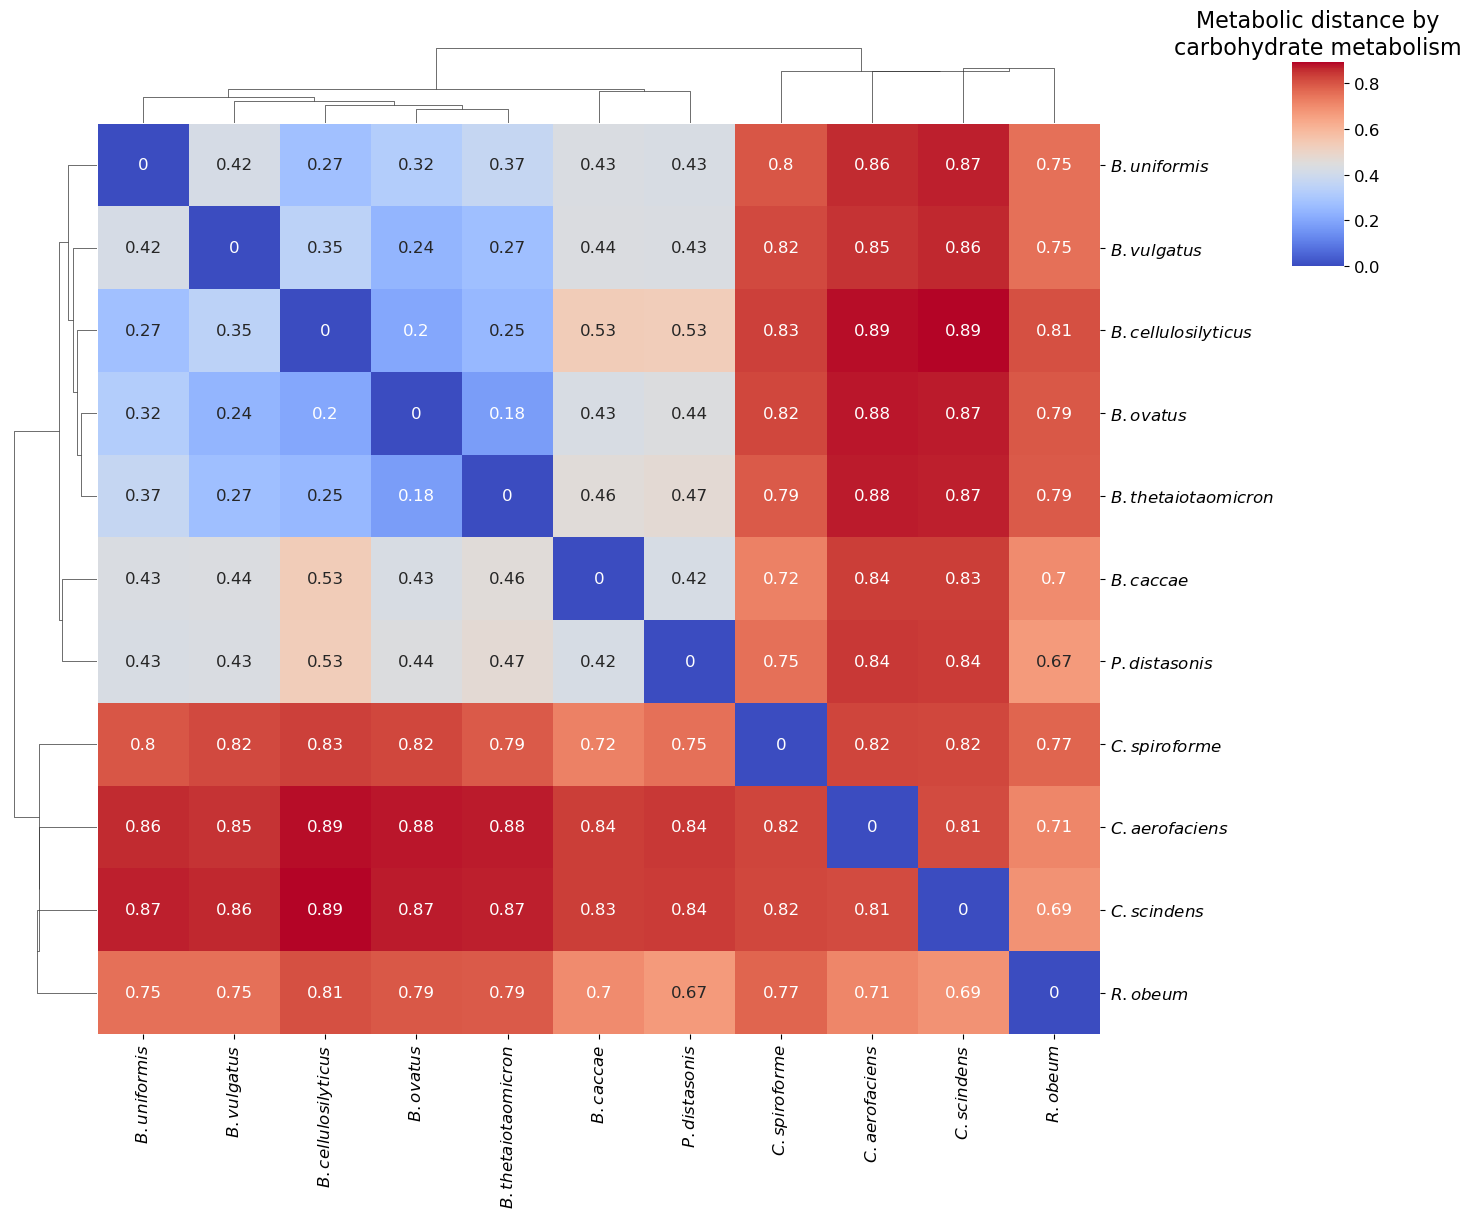

In [127]:
ax = sns.clustermap(metdist_carbo_pretty, 
    metric='euclidean', 
    method='centroid',
    cmap="coolwarm", 
    row_cluster=True, 
    col_cluster=True,
    dendrogram_ratio=(0.08, 0.08), 
    annot=True, 
    cbar_pos=(1, 0.8, 0.04, 0.17),
    yticklabels='auto',
    xticklabels='auto',
    figsize=(13, 12))
plt.title('Metabolic distance by\ncarbohydrate metabolism', fontsize=16)
plt.savefig('metabolic-metrics/metdist_carbo.pdf', bbox_inches='tight')
plt.show()

In [128]:
metaddinfo_carbo = get_added_information(dbCAN_sub)
metaddinfo_carbo = metaddinfo_carbo.sort_index(axis=0).sort_index(axis=1)
metaddinfo_carbo.to_csv('metabolic-metrics/metaddinfo_carbo.tsv', sep='\t', index=True, header=True)
metaddinfo_carbo_pretty = metaddinfo_carbo.copy()
metaddinfo_carbo_pretty.columns = metaddinfo_carbo_pretty.columns.map(pretty_names_dir)
metaddinfo_carbo_pretty.index = metaddinfo_carbo_pretty.index.map(pretty_names_dir)
metaddinfo_carbo_pretty

,$B. caccae$,$B. cellulosilyticus$,$B. ovatus$,$B. thetaiotaomicron$,$B. uniformis$,$B. vulgatus$,$C. aerofaciens$,$C. scindens$,$C. spiroforme$,$P. distasonis$,$R. obeum$
$B. caccae$,0.000000,13.850842,10.822598,10.767870,8.502840,7.711749,0.984591,2.302867,2.844316,4.924144,2.742020
$B. cellulosilyticus$,2.471199,0.000000,1.922589,2.194440,1.308918,1.704598,0.653971,2.302867,3.076735,2.828721,2.742020
$B. ovatus$,1.076555,3.556188,0.000000,1.924786,2.970450,0.684969,0.653971,1.972247,3.174936,1.846327,2.742020
$B. thetaiotaomicron$,1.789294,4.595508,2.692254,0.000000,4.037540,1.397709,0.653971,1.972247,2.476461,2.572572,2.742020
$B. uniformis$,2.323746,6.509467,6.537400,6.837022,0.000000,5.266585,0.653971,2.302867,2.977718,2.739169,2.353714
$B. vulgatus$,3.115812,8.488305,5.835076,5.780348,6.849742,0.000000,0.653971,2.302867,3.836175,3.601666,2.742020
$C. aerofaciens$,11.837824,22.886848,21.253248,20.485780,17.686298,16.103141,0.000000,3.212687,5.841090,12.673559,4.535258
$C. scindens$,11.429665,22.809308,20.845089,20.077621,17.608758,16.025602,1.486252,0.000000,5.242766,12.265400,3.793415
$C. spiroforme$,9.256066,20.868128,19.332729,17.866787,15.568561,14.843861,1.399607,2.527718,0.000000,10.385186,3.967722
$P. distasonis$,4.088409,13.372629,10.756636,10.715412,8.082527,7.361867,0.984591,2.302867,3.137700,0.000000,2.099784


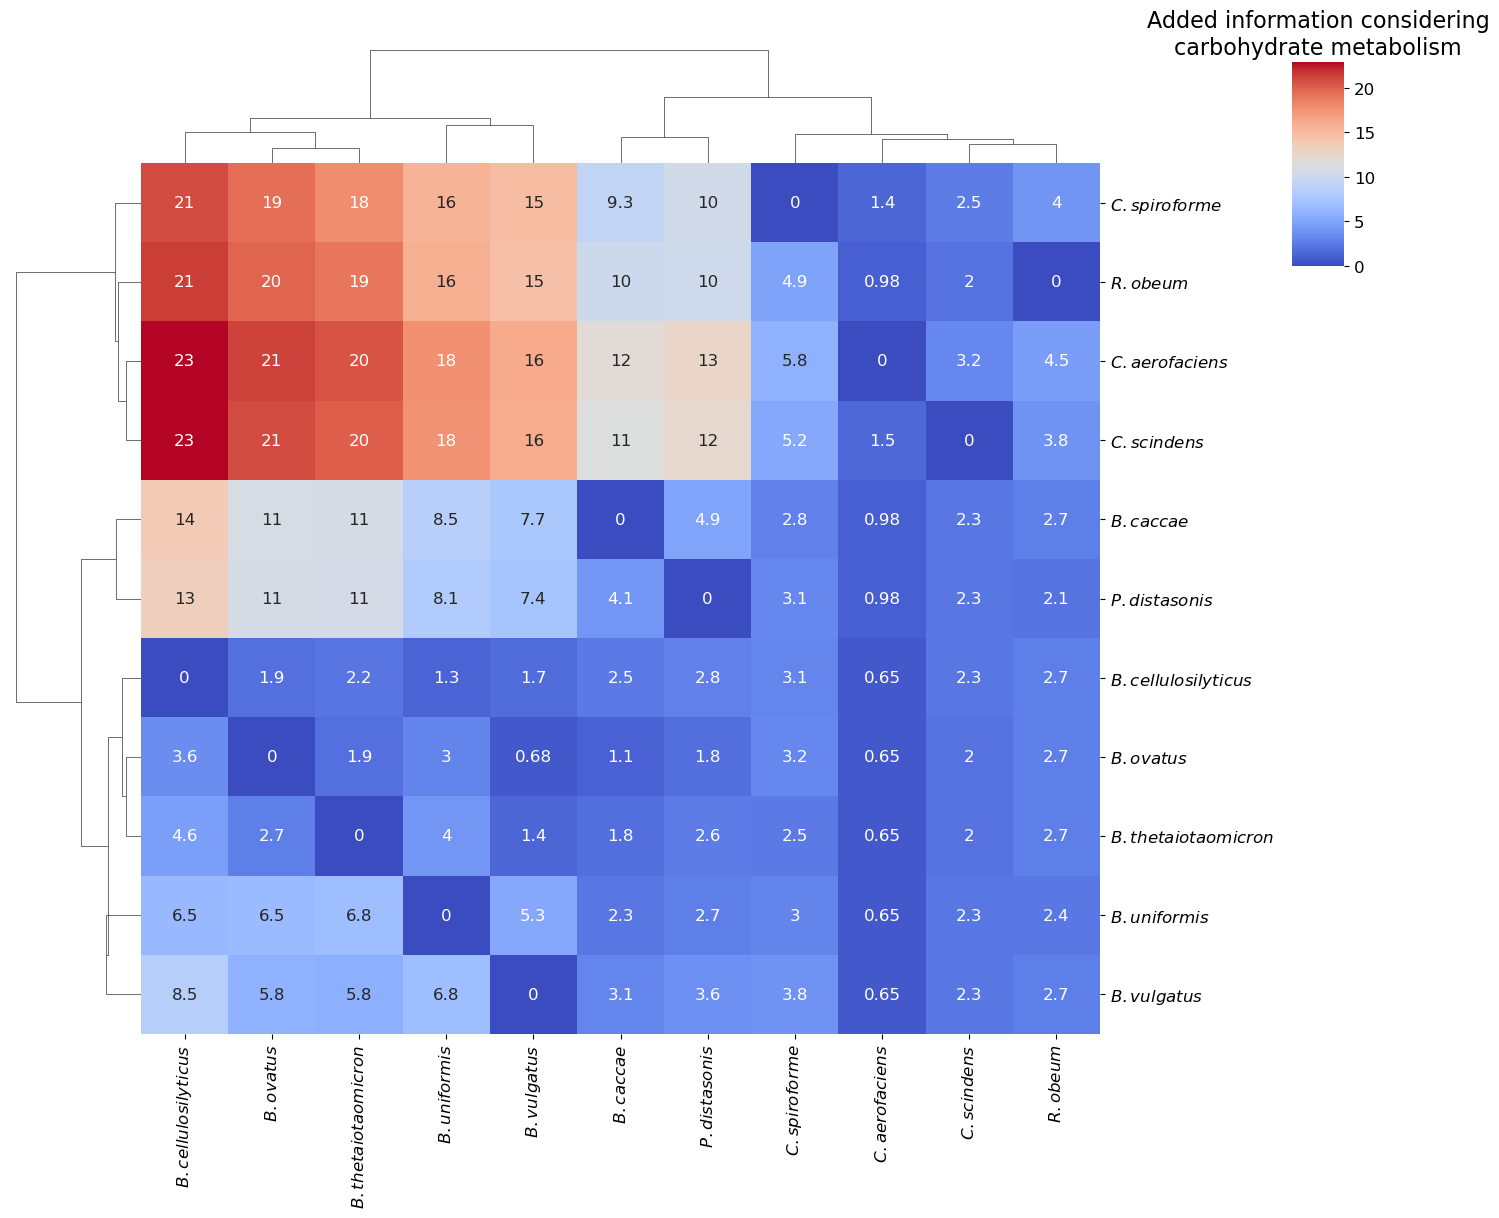

In [129]:
sns.clustermap(metaddinfo_carbo_pretty, 
    metric= 'euclidean', 
    method='centroid', 
    cmap="coolwarm", 
    dendrogram_ratio=(0.12, 0.12), 
    annot=True, 
    cbar_pos=(1, 0.8, 0.04, 0.17), 
    figsize=(13, 12), 
    row_cluster=True)
plt.title('Added information considering\ncarbohydrate metabolism', fontsize=16)
plt.savefig('metabolic-metrics/metaddinfo_carbo.pdf', bbox_inches='tight')
plt.show()

# Amino Acid Metabolism

 ## Metabolic distance and Metabolic Added Information

In [130]:
eggNOG = []
for taxon in taxa:
    aminoacid_metabolism = pd.read_table(f'eggNOG/{taxon}_eggNOG.tsv', index_col=0, skiprows=4, skipfooter=3, engine='python')
    aminoacid_metabolism['Species'] = taxon
    aminoacid_metabolism = aminoacid_metabolism[aminoacid_metabolism['COG_category'].apply(get_aminoacid_metabolism)].copy()
    aminoacid_metabolism = aminoacid_metabolism[aminoacid_metabolism['EC'] != '-'].copy()
    aminoacid_metabolism.drop_duplicates(subset=['EC'], inplace=True)
    aminoacid_metabolism.set_index('EC', inplace=True)
    aminoacid_metabolism = aminoacid_metabolism.loc[:,['Species']].copy()
    aminoacid_metabolism.columns = [aminoacid_metabolism['Species'][0]]
    eggNOG.append(aminoacid_metabolism)
eggNOG = pd.concat(eggNOG, axis=1)
eggNOG = eggNOG.applymap(presence_absence)
eggNOG 

,B_cellulosilyticus_WH2,B_caccae,B_vulgatus,B_thetaiotaomicron,B_ovatus,R_obeum,B_uniformis,P_distasonis,C_scindens,C_aerofaciens,C_spiroforme
EC,,,,,,,,,,,
4.3.2.1,1,1,1,1,1,1,1,1,1,1,0
2.7.2.11,1,1,1,1,1,0,1,1,0,1,1
1.2.1.41,1,1,1,1,1,1,1,1,1,1,1
"2.1.3.11,2.1.3.9",1,1,1,1,1,0,1,1,0,0,0
1.2.1.11,1,1,1,1,1,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
3.4.17.19,0,0,0,0,0,0,0,0,0,1,0
"1.1.1.399,1.1.1.95",0,0,0,0,0,0,0,0,0,1,0
2.4.2.17,0,0,0,0,0,0,0,0,0,1,0


In [131]:
metdist_amino = calculate_metabolic_distance(eggNOG)
metdist_amino = metdist_amino.sort_index(axis=0).sort_index(axis=1)
metdist_amino.to_csv('metabolic-metrics/metdist_amino.tsv', sep='\t', index=True, header=True)
metdist_amino_pretty = metdist_amino.copy()
metdist_amino_pretty.columns = metdist_amino_pretty.columns.map(pretty_names_dir)
metdist_amino_pretty.index = metdist_amino_pretty.index.map(pretty_names_dir)
metdist_amino_pretty

,$B. caccae$,$B. cellulosilyticus$,$B. ovatus$,$B. thetaiotaomicron$,$B. uniformis$,$B. vulgatus$,$C. aerofaciens$,$C. scindens$,$C. spiroforme$,$P. distasonis$,$R. obeum$
$B. caccae$,0.000000,0.166667,0.080000,0.070000,0.144231,0.172727,0.666667,0.647059,0.891089,0.280000,0.669231
$B. cellulosilyticus$,0.166667,0.000000,0.112150,0.137615,0.154545,0.181034,0.691729,0.664062,0.900901,0.333333,0.664234
$B. ovatus$,0.080000,0.112150,0.000000,0.087379,0.141509,0.169643,0.677165,0.658537,0.895238,0.302326,0.679104
$B. thetaiotaomicron$,0.070000,0.137615,0.087379,0.000000,0.132075,0.160714,0.679688,0.661290,0.896226,0.294574,0.671642
$B. uniformis$,0.144231,0.154545,0.141509,0.132075,0.000000,0.176991,0.669291,0.639344,0.885714,0.307692,0.651515
$B. vulgatus$,0.172727,0.181034,0.169643,0.160714,0.176991,0.000000,0.679104,0.661538,0.893805,0.298507,0.671429
$C. aerofaciens$,0.666667,0.691729,0.677165,0.679688,0.669291,0.679104,0.000000,0.510870,0.857143,0.709459,0.539216
$C. scindens$,0.647059,0.664062,0.658537,0.661290,0.639344,0.661538,0.510870,0.000000,0.835616,0.676056,0.510204
$C. spiroforme$,0.891089,0.900901,0.895238,0.896226,0.885714,0.893805,0.857143,0.835616,0.000000,0.905512,0.885057
$P. distasonis$,0.280000,0.333333,0.302326,0.294574,0.307692,0.298507,0.709459,0.676056,0.905512,0.000000,0.666667


/home/acs98/anaconda3/envs/py-workspace/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


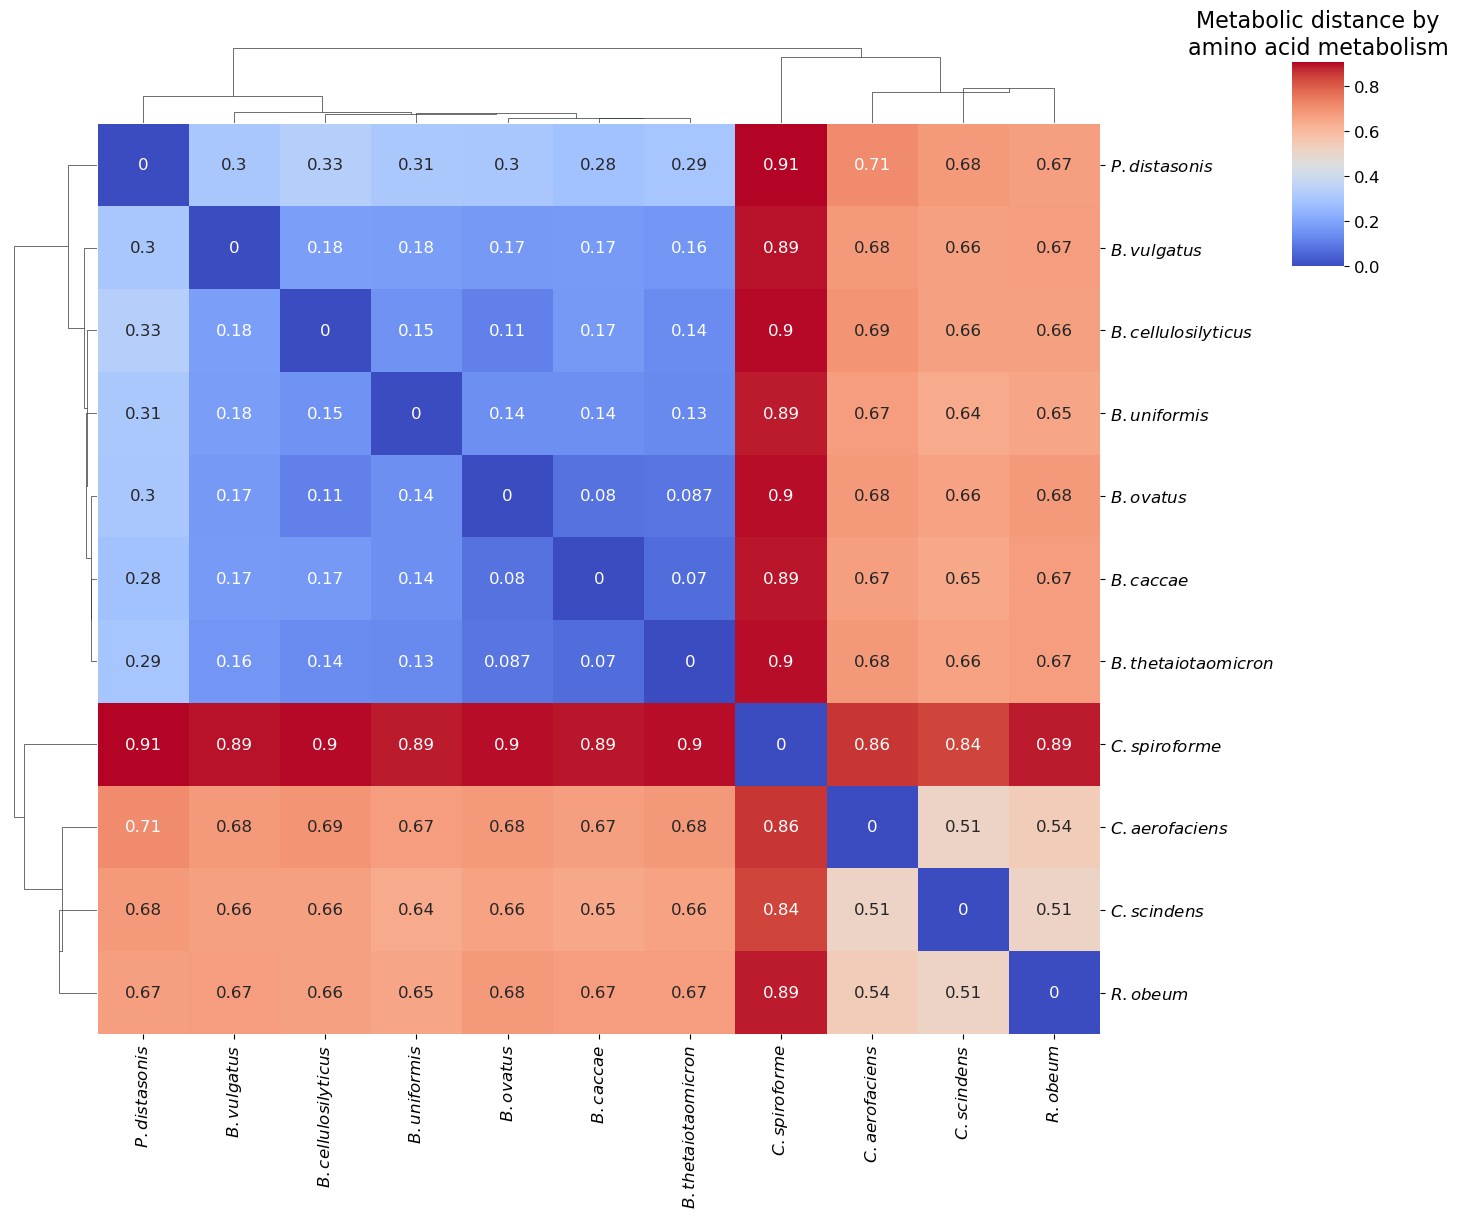

In [132]:
ax = sns.clustermap(metdist_amino_pretty, 
    metric='euclidean', 
    method='centroid',
    cmap="coolwarm", 
    row_cluster=True, 
    col_cluster=True,
    dendrogram_ratio=(0.08, 0.08), 
    annot=True, 
    cbar_pos=(1, 0.8, 0.04, 0.17),
    yticklabels='auto',
    xticklabels='auto',
    figsize=(13, 12))
plt.title('Metabolic distance by\namino acid metabolism', fontsize=16)
plt.savefig('metabolic-metrics/metdist_amino.pdf', bbox_inches='tight')
plt.show()

In [133]:
metaddinfo_amino = get_added_information(eggNOG)
metaddinfo_amino = metaddinfo_amino.sort_index(axis=0).sort_index(axis=1)
metaddinfo_amino.to_csv('metabolic-metrics/metaddinfo_amino.tsv', sep='\t', index=True, header=True)
metaddinfo_amino_pretty = metaddinfo_amino.copy()
metaddinfo_amino_pretty.columns = metaddinfo_amino_pretty.columns.map(pretty_names_dir)
metaddinfo_amino_pretty.index = metaddinfo_amino_pretty.index.map(pretty_names_dir)
metaddinfo_amino_pretty

,$B. caccae$,$B. cellulosilyticus$,$B. ovatus$,$B. thetaiotaomicron$,$B. uniformis$,$B. vulgatus$,$C. aerofaciens$,$C. scindens$,$C. spiroforme$,$P. distasonis$,$R. obeum$
$B. caccae$,0.000000,4.374452,2.084983,2.016857,3.100572,5.106990,8.830213,8.081213,2.439333,8.179414,11.214818
$B. cellulosilyticus$,1.452489,0.000000,1.084634,1.714008,1.744899,3.813256,8.830213,7.750594,2.439333,8.285695,10.243625
$B. ovatus$,0.735710,2.657324,0.000000,1.686238,2.402098,4.422020,8.830213,8.081213,2.439333,8.230155,11.214818
$B. thetaiotaomicron$,0.358390,2.977503,1.377044,0.000000,2.119914,4.126331,8.830213,8.081213,2.439333,7.876565,10.884199
$B. uniformis$,1.820344,3.386633,2.471143,2.498153,0.000000,4.514796,8.499594,7.419974,2.108714,8.318891,10.243625
$B. vulgatus$,0.899895,2.528125,1.564199,1.577704,1.587929,0.000000,7.999475,7.216304,2.108714,6.769068,9.995560
$C. aerofaciens$,14.224014,17.145977,15.573287,15.882481,15.173622,17.600370,0.000000,5.371513,1.552647,20.411203,8.003102
$C. scindens$,13.936387,16.527730,15.285660,15.594854,14.555376,17.278573,5.832886,0.000000,1.198297,19.358379,7.570186
$C. spiroforme$,17.588655,20.510618,18.937929,19.247123,18.538264,21.465130,11.308169,10.492446,0.000000,24.130194,14.598412
$P. distasonis$,1.307256,4.335499,2.707270,2.662874,2.726960,4.104004,8.145244,6.631046,2.108714,0.000000,8.812720


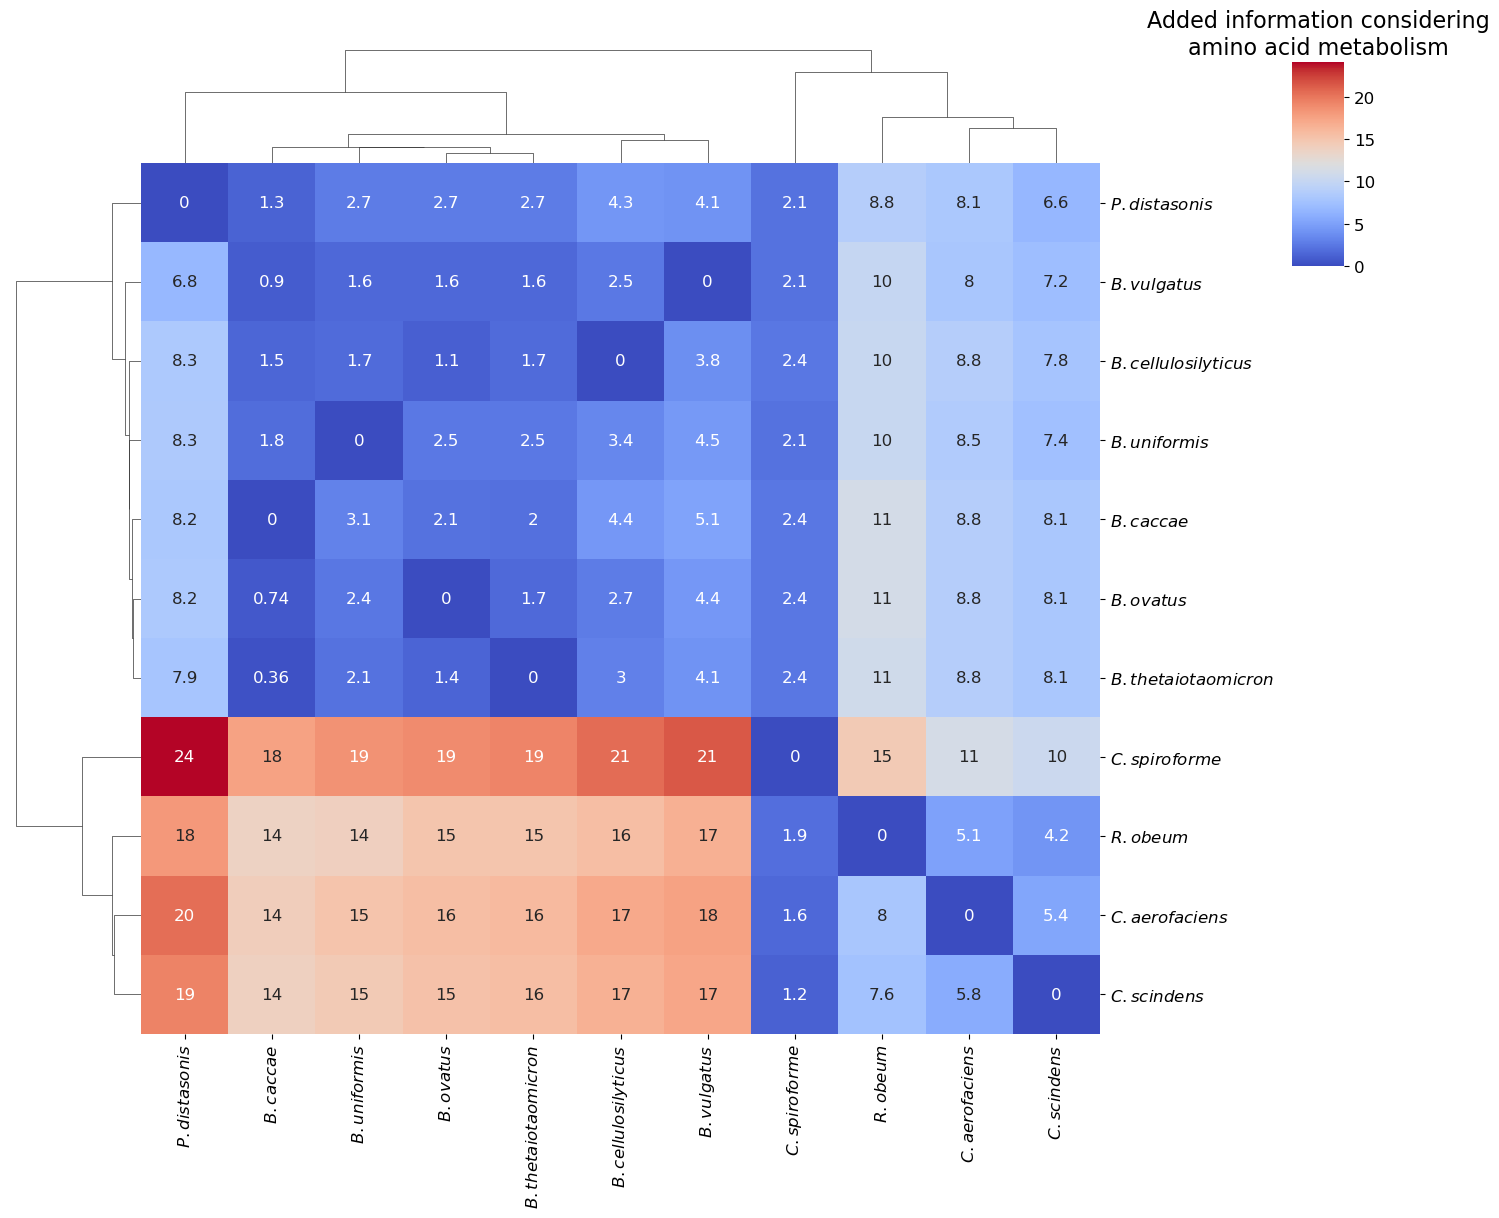

In [134]:
sns.clustermap(metaddinfo_amino_pretty, 
    metric= 'euclidean', 
    method='centroid', 
    cmap="coolwarm", 
    dendrogram_ratio=(0.12, 0.12), 
    annot=True, 
    cbar_pos=(1, 0.8, 0.04, 0.17), 
    figsize=(13, 12), 
    row_cluster=True)
plt.title('Added information considering\namino acid metabolism', fontsize=16)
plt.savefig('metabolic-metrics/metaddinfo_amino.pdf', bbox_inches='tight')
plt.show()

# Carbohydrate and Amino Acid Metabolism

 ## Metabolic Distance and Metabolic Added Information

In [135]:
dbCAN_sub_eggNOG = pd.concat([dbCAN_sub, eggNOG], axis=0)
dbCAN_sub_eggNOG

,B_cellulosilyticus_WH2,B_caccae,B_vulgatus,B_thetaiotaomicron,B_ovatus,R_obeum,B_uniformis,P_distasonis,C_scindens,C_aerofaciens,C_spiroforme
3.2.1.55,1,1,1,1,1,1,1,1,0,0,0
3.2.1.37,1,1,1,1,1,1,1,1,0,1,1
3.2.1.,1,1,1,1,1,1,1,1,1,1,1
3.2.1.92,1,0,0,0,0,0,1,0,0,0,0
3.2.1.21,1,1,1,1,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
3.4.17.19,0,0,0,0,0,0,0,0,0,1,0
"1.1.1.399,1.1.1.95",0,0,0,0,0,0,0,0,0,1,0
2.4.2.17,0,0,0,0,0,0,0,0,0,1,0
3.6.1.31,0,0,0,0,0,0,0,0,0,1,0


In [136]:
metdist_carbo_amino = calculate_metabolic_distance(dbCAN_sub_eggNOG)
metdist_carbo_amino = metdist_carbo_amino.sort_index(axis=0).sort_index(axis=1)
metdist_carbo_amino.to_csv('metabolic-metrics/metdist_carbo_amino.tsv', sep='\t', index=True, header=True)
metdist_carbo_amino_pretty = metdist_carbo_amino.copy()
metdist_carbo_amino_pretty.columns = metdist_carbo_amino_pretty.columns.map(pretty_names_dir)
metdist_carbo_amino_pretty.index = metdist_carbo_amino_pretty.index.map(pretty_names_dir)
metdist_carbo_amino_pretty

,$B. caccae$,$B. cellulosilyticus$,$B. ovatus$,$B. thetaiotaomicron$,$B. uniformis$,$B. vulgatus$,$C. aerofaciens$,$C. scindens$,$C. spiroforme$,$P. distasonis$,$R. obeum$
$B. caccae$,0.000000,0.335000,0.236264,0.245902,0.266667,0.278689,0.719101,0.709497,0.827160,0.329843,0.678947
$B. cellulosilyticus$,0.335000,0.000000,0.152284,0.189055,0.207071,0.253659,0.768182,0.760181,0.868932,0.412281,0.721739
$B. ovatus$,0.236264,0.152284,0.000000,0.127660,0.222798,0.197917,0.754808,0.746411,0.860825,0.356808,0.723982
$B. thetaiotaomicron$,0.245902,0.189055,0.127660,0.000000,0.241026,0.207254,0.754808,0.746411,0.848958,0.364486,0.718182
$B. uniformis$,0.266667,0.207071,0.222798,0.241026,0.000000,0.280612,0.737374,0.728643,0.847826,0.352657,0.687500
$B. vulgatus$,0.278689,0.253659,0.197917,0.207254,0.280612,0.000000,0.735000,0.732673,0.862434,0.346154,0.698113
$C. aerofaciens$,0.719101,0.768182,0.754808,0.754808,0.737374,0.735000,0.000000,0.579832,0.846847,0.746341,0.578947
$C. scindens$,0.709497,0.760181,0.746411,0.746411,0.728643,0.732673,0.579832,0.000000,0.830357,0.725490,0.556391
$C. spiroforme$,0.827160,0.868932,0.860825,0.848958,0.847826,0.862434,0.846847,0.830357,0.000000,0.853403,0.847328
$P. distasonis$,0.329843,0.412281,0.356808,0.364486,0.352657,0.346154,0.746341,0.725490,0.853403,0.000000,0.666667


/home/acs98/anaconda3/envs/py-workspace/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


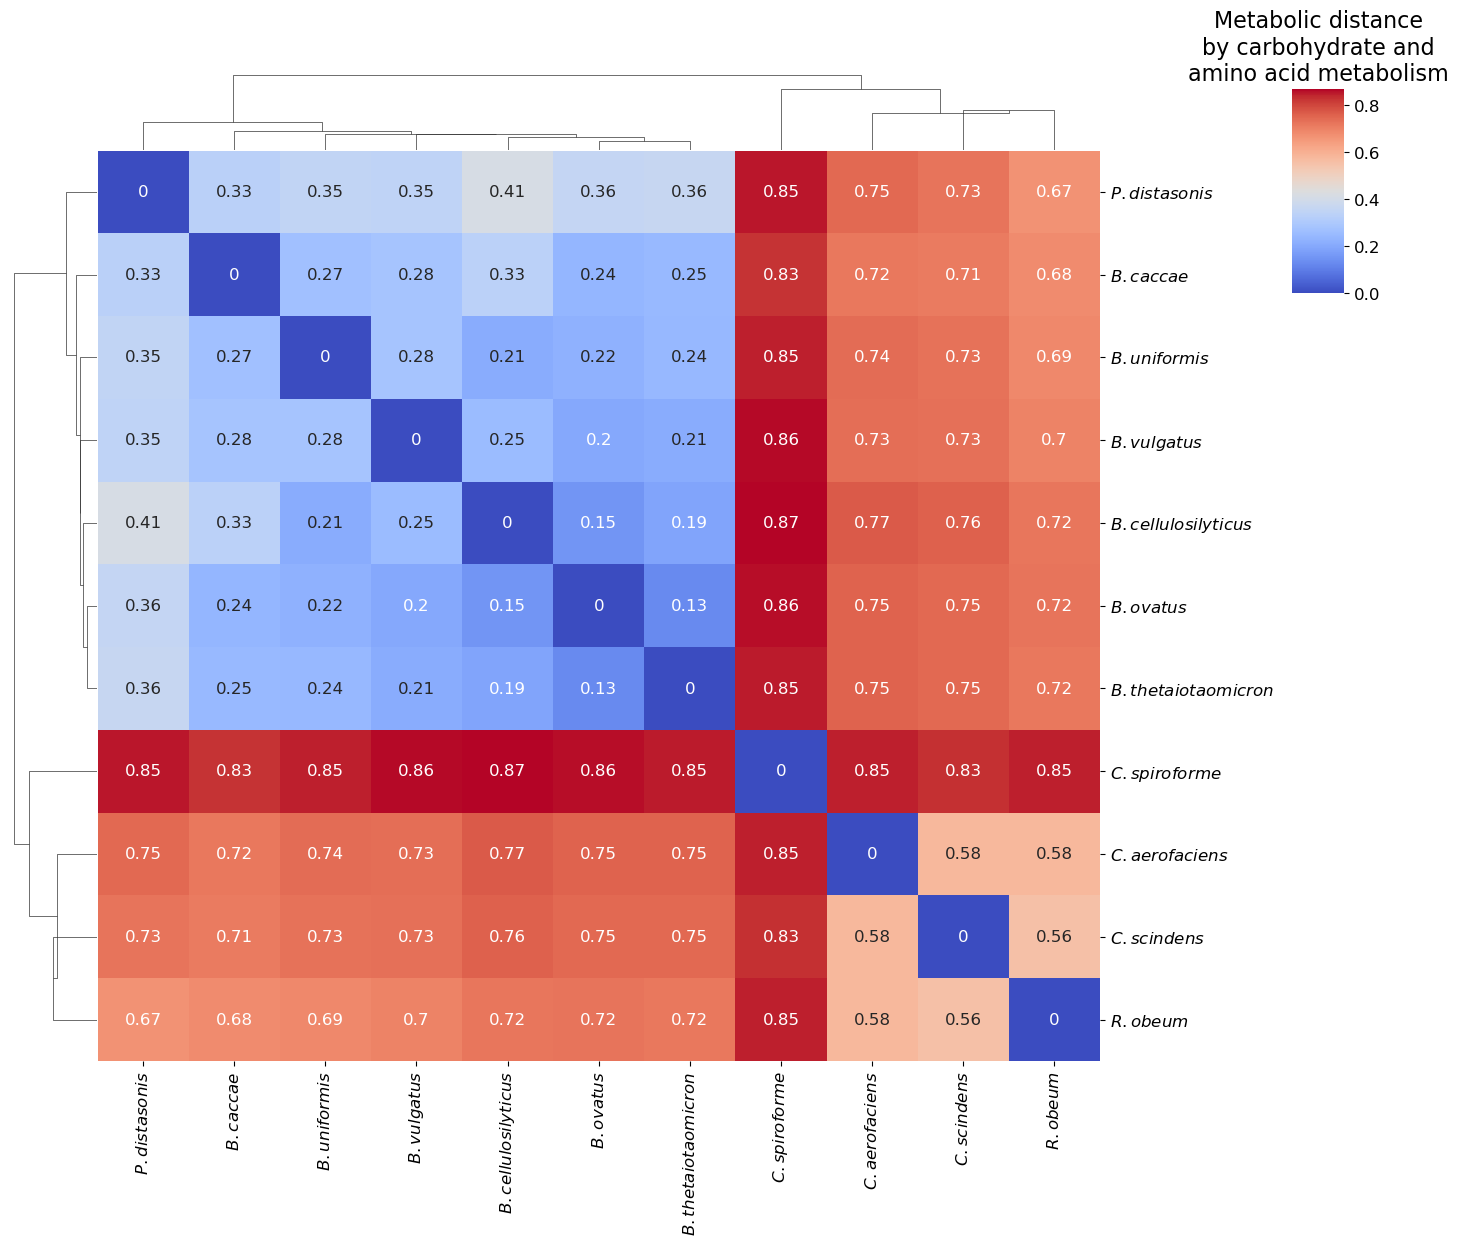

In [137]:
ax = sns.clustermap(metdist_carbo_amino_pretty, 
    metric='euclidean', 
    method='centroid',
    cmap="coolwarm", 
    row_cluster=True, 
    col_cluster=True,
    dendrogram_ratio=(0.08, 0.08), 
    annot=True, 
    cbar_pos=(1, 0.8, 0.04, 0.17),
    yticklabels='auto',
    xticklabels='auto',
    figsize=(13, 12))
plt.title('Metabolic distance\nby carbohydrate and\namino acid metabolism', fontsize=16)
plt.savefig('metabolic-metrics/metdist_carbo_amino.pdf', bbox_inches='tight')
plt.show()

In [138]:
metaddinfo_carbo_amino = get_added_information(dbCAN_sub_eggNOG)
metaddinfo_carbo_amino = metaddinfo_carbo_amino.sort_index(axis=0).sort_index(axis=1)
metaddinfo_carbo_amino.to_csv('metabolic-metrics/metaddinfo_carbo_amino.tsv', sep='\t', index=True, header=True)
metaddinfo_carbo_amino_pretty = metaddinfo_carbo_amino.copy()
metaddinfo_carbo_amino_pretty.columns = metaddinfo_carbo_amino_pretty.columns.map(pretty_names_dir)
metaddinfo_carbo_amino_pretty.index = metaddinfo_carbo_amino_pretty.index.map(pretty_names_dir)
metaddinfo_carbo_amino_pretty

,$B. caccae$,$B. cellulosilyticus$,$B. ovatus$,$B. thetaiotaomicron$,$B. uniformis$,$B. vulgatus$,$C. aerofaciens$,$C. scindens$,$C. spiroforme$,$P. distasonis$,$R. obeum$
$B. caccae$,0.000000,19.997203,14.311635,14.352966,11.603412,14.754832,9.814804,10.384080,5.283649,13.103558,13.956838
$B. cellulosilyticus$,3.923688,0.000000,3.007223,4.072633,3.053816,5.682040,9.484185,10.053460,5.516068,11.114416,12.985645
$B. ovatus$,1.812264,6.581367,0.000000,3.775209,5.372548,5.639030,9.484185,10.053460,5.614269,10.076482,13.956838
$B. thetaiotaomicron$,2.147684,7.940866,4.069298,0.000000,6.157454,5.891895,9.484185,10.053460,4.915794,10.449137,13.626219
$B. uniformis$,4.511945,12.035864,10.780452,11.271268,0.000000,12.085330,9.153565,9.722841,5.086431,11.058060,12.597339
$B. vulgatus$,4.015707,11.016429,7.399275,7.358052,8.437672,0.000000,8.653446,9.519171,5.944888,10.370734,12.737579
$C. aerofaciens$,26.429692,42.172588,38.598444,38.304355,32.859920,36.007459,0.000000,8.584200,7.393737,33.084762,12.538361
$C. scindens$,26.043861,41.786756,38.212612,37.918523,32.474089,35.918077,7.629093,0.000000,6.441063,31.933733,11.673555
$C. spiroforme$,27.522530,43.828464,40.352521,39.359957,34.416780,38.922894,13.017730,13.020163,0.000000,34.825334,18.876088
$P. distasonis$,5.763519,19.847891,15.235814,15.314380,10.809487,13.769819,9.129835,8.933913,5.246414,0.000000,10.912504


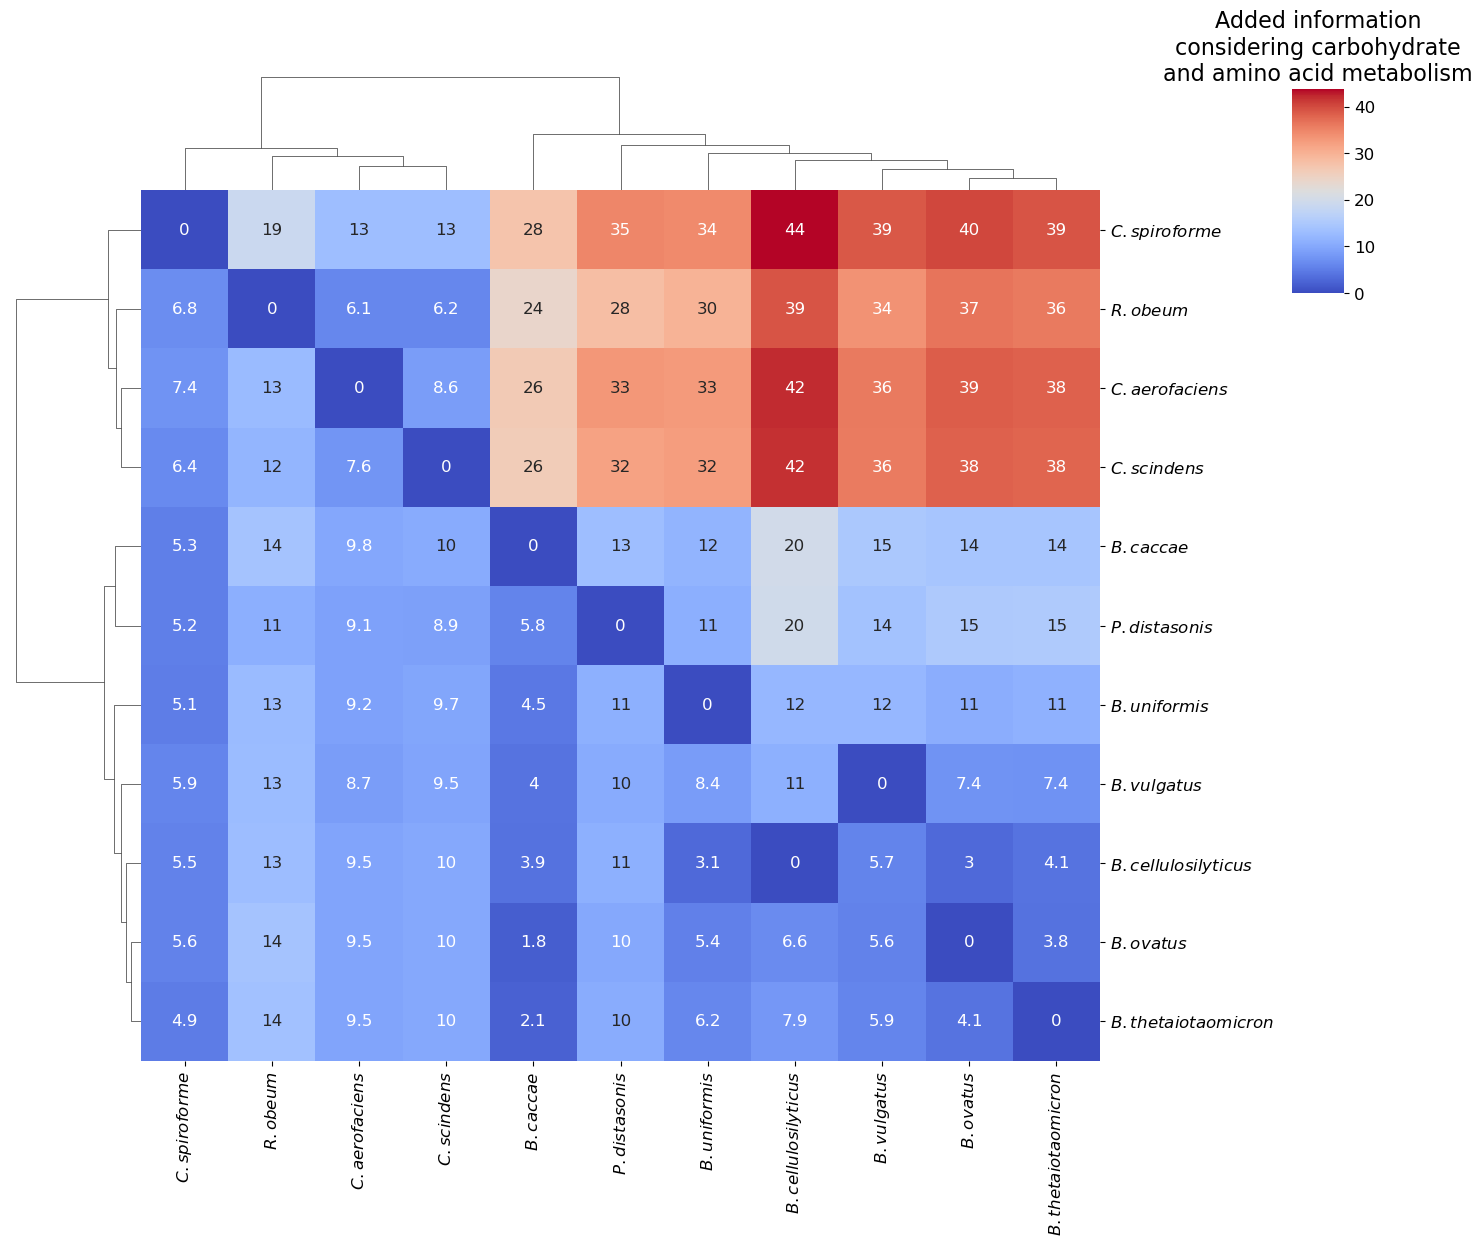

In [139]:
sns.clustermap(metaddinfo_carbo_amino_pretty, 
    metric= 'euclidean', 
    method='centroid', 
    cmap="coolwarm", 
    dendrogram_ratio=(0.12, 0.12), 
    annot=True, 
    cbar_pos=(1, 0.8, 0.04, 0.17), 
    figsize=(13, 12), 
    row_cluster=True)
plt.title('Added information\nconsidering carbohydrate\nand amino acid metabolism', fontsize=16)
plt.savefig('metabolic-metrics/metaddinfo_carbo_amino.pdf', bbox_inches='tight')
plt.show()